In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
dividend = pd.read_csv('/Users/liyihan/Desktop/Work/ASL/ETF Hedging Data/ETF/processed data/etf_dividends.csv')
dividend = dividend.rename(columns={'Unnamed: 0': 'Date', 'BILS': 'BILS_Dividend', 'USFR': 'USFR_Dividend', 'BIL': 'BIL_Dividend', 'SGOV': 'SGOV_Dividend', 'IEF': 'IEF_Dividend', 'TLT': 'TLT_Dividend'})
dividend['Date'] = pd.to_datetime(dividend['Date'])
dividend.set_index('Date', inplace=True)
dividend

,BILS_Dividend,USFR_Dividend,BIL_Dividend,SGOV_Dividend,IEF_Dividend,TLT_Dividend
Date,,,,,,
2021-02-01,NaN,NaN,NaN,0.005,0.078,0.176
2021-03-01,NaN,NaN,NaN,NaN,0.070,0.172
2021-04-01,NaN,NaN,NaN,NaN,0.070,0.185
2021-05-03,NaN,NaN,NaN,0.004,0.074,0.203
2021-06-01,NaN,NaN,NaN,0.002,0.079,0.199
...,...,...,...,...,...,...
2024-05-01,0.417,NaN,0.388,0.428,0.271,0.308
2024-05-24,NaN,0.227,NaN,NaN,NaN,NaN
2024-06-03,0.434,NaN,0.405,0.440,0.276,0.308


In [7]:
data = pd.read_csv('/Users/liyihan/Desktop/Work/ASL/ETF Hedging Data/ETF/processed data/NAV.csv')
data = data.rename(columns={'navDate': 'Date'})
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)
data = data.join(dividend, how='left')
data = data.fillna(0)
data

,BILS,USFR,BIL,SGOV,IEF,TLT,BILS_Dividend,USFR_Dividend,BIL_Dividend,SGOV_Dividend,IEF_Dividend,TLT_Dividend
Date,,,,,,,,,,,,
2021-01-04,100.070350,25.106475,91.514454,100.015801,119.980988,157.692532,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,100.070896,25.105846,91.513935,100.014627,119.649902,156.134543,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-06,100.067845,25.105469,91.512743,100.014484,118.876441,152.696190,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-07,100.065672,25.106960,91.512812,100.014396,118.605299,152.014162,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-08,100.069879,25.107591,91.513138,100.014749,118.273899,151.475418,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-26,99.321171,50.285369,91.749357,100.664438,92.795146,91.292031,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-27,99.321171,50.285369,91.749357,100.664438,92.795146,91.292031,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-28,99.332089,50.317386,91.761958,100.678521,92.336797,90.038392,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def cal_Shares(df, name):
    column_dividend = name + '_Dividend'
    column_shares = name + '_Shares'
    df[column_shares] = 1
    column_adj = name + '_Reinvested'
    for i in range(1, len(df)):
        df.iloc[i, df.columns.get_loc(column_shares)] = (
            df.iloc[i-1, df.columns.get_loc(column_shares)] * 
            (1 + df.iloc[i-1, df.columns.get_loc(column_dividend)] / df.iloc[i, df.columns.get_loc(name)])
        )
    df[column_adj] = df[name] * df[column_shares]
    df.drop(columns=[column_dividend], inplace=True, errors='ignore')
    return df

etfs = ['BILS', 'USFR', 'BIL', 'SGOV', 'IEF', 'TLT']
shares = pd.DataFrame(index=data.index)
for etf in etfs:
    data = cal_Shares(data, etf)
    column_shares = etf + '_Shares'
    shares[etf] = data[column_shares]
    
data

,BILS,USFR,BIL,SGOV,IEF,TLT,BILS_Shares,BILS_Reinvested,USFR_Shares,USFR_Reinvested,BIL_Shares,BIL_Reinvested,SGOV_Shares,SGOV_Reinvested,IEF_Shares,IEF_Reinvested,TLT_Shares,TLT_Reinvested
Date,,,,,,,,,,,,,,,,,,
2021-01-04,100.070350,25.106475,91.514454,100.015801,119.980988,157.692532,1.000000,100.070350,1.000000,25.106475,1.000000,91.514454,1.000000,100.015801,1.000000,119.980988,1.000000,157.692532
2021-01-05,100.070896,25.105846,91.513935,100.014627,119.649902,156.134543,1.000000,100.070896,1.000000,25.105846,1.000000,91.513935,1.000000,100.014627,1.000000,119.649902,1.000000,156.134543
2021-01-06,100.067845,25.105469,91.512743,100.014484,118.876441,152.696190,1.000000,100.067845,1.000000,25.105469,1.000000,91.512743,1.000000,100.014484,1.000000,118.876441,1.000000,152.696190
2021-01-07,100.065672,25.106960,91.512812,100.014396,118.605299,152.014162,1.000000,100.065672,1.000000,25.106960,1.000000,91.512812,1.000000,100.014396,1.000000,118.605299,1.000000,152.014162
2021-01-08,100.069879,25.107591,91.513138,100.014749,118.273899,151.475418,1.000000,100.069879,1.000000,25.107591,1.000000,91.513138,1.000000,100.014749,1.000000,118.273899,1.000000,151.475418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-26,99.321171,50.285369,91.749357,100.664438,92.795146,91.292031,1.086588,107.921211,1.090742,54.848341,1.082861,99.351797,1.084227,109.143101,1.069568,99.250755,1.089617,99.473336
2024-05-27,99.321171,50.285369,91.749357,100.664438,92.795146,91.292031,1.086588,107.921211,1.090742,54.848341,1.082861,99.351797,1.084227,109.143101,1.069568,99.250755,1.089617,99.473336
2024-05-28,99.332089,50.317386,91.761958,100.678521,92.336797,90.038392,1.086588,107.933074,1.090742,54.883263,1.082861,99.365442,1.084227,109.158371,1.069568,98.760518,1.089617,98.107350


In [42]:
shares

,BILS,USFR,BIL,SGOV,IEF,TLT
Date,,,,,,
2021-01-04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-01-05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-01-06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-01-07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2021-01-08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
2024-05-26,1.086588,1.090742,1.082861,1.084227,1.069568,1.089617
2024-05-27,1.086588,1.090742,1.082861,1.084227,1.069568,1.089617
2024-05-28,1.086588,1.090742,1.082861,1.084227,1.069568,1.089617


In [9]:
data.drop(columns=['BILS_Shares', 'USFR_Shares', 'BIL_Shares', 'SGOV_Shares', 'IEF_Shares', 'TLT_Shares'], inplace=True, errors='ignore')
returns = data.pct_change().dropna()
returns = returns.join(dividend, how='left')
returns = returns.fillna(0)
returns

,BILS,USFR,BIL,SGOV,IEF,TLT,BILS_Reinvested,USFR_Reinvested,BIL_Reinvested,SGOV_Reinvested,IEF_Reinvested,TLT_Reinvested,BILS_Dividend,USFR_Dividend,BIL_Dividend,SGOV_Dividend,IEF_Dividend,TLT_Dividend
Date,,,,,,,,,,,,,,,,,,
2021-01-05,0.000005,-0.000025,-5.671235e-06,-1.173815e-05,-0.002759,-0.009880,0.000005,-0.000025,-5.671235e-06,-1.173815e-05,-0.002759,-0.009880,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-06,-0.000030,-0.000015,-1.302534e-05,-1.429791e-06,-0.006464,-0.022022,-0.000030,-0.000015,-1.302534e-05,-1.429791e-06,-0.006464,-0.022022,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-07,-0.000022,0.000059,7.539934e-07,-8.798726e-07,-0.002281,-0.004467,-0.000022,0.000059,7.539934e-07,-8.798726e-07,-0.002281,-0.004467,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-08,0.000042,0.000025,3.562343e-06,3.529492e-06,-0.002794,-0.003544,0.000042,0.000025,3.562343e-06,3.529492e-06,-0.002794,-0.003544,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-09,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-26,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-27,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-28,0.000110,0.000637,1.373416e-04,1.399080e-04,-0.004939,-0.013732,0.000110,0.000637,1.373416e-04,1.399080e-04,-0.004939,-0.013732,0.0,0.0,0.0,0.0,0.0,0.0


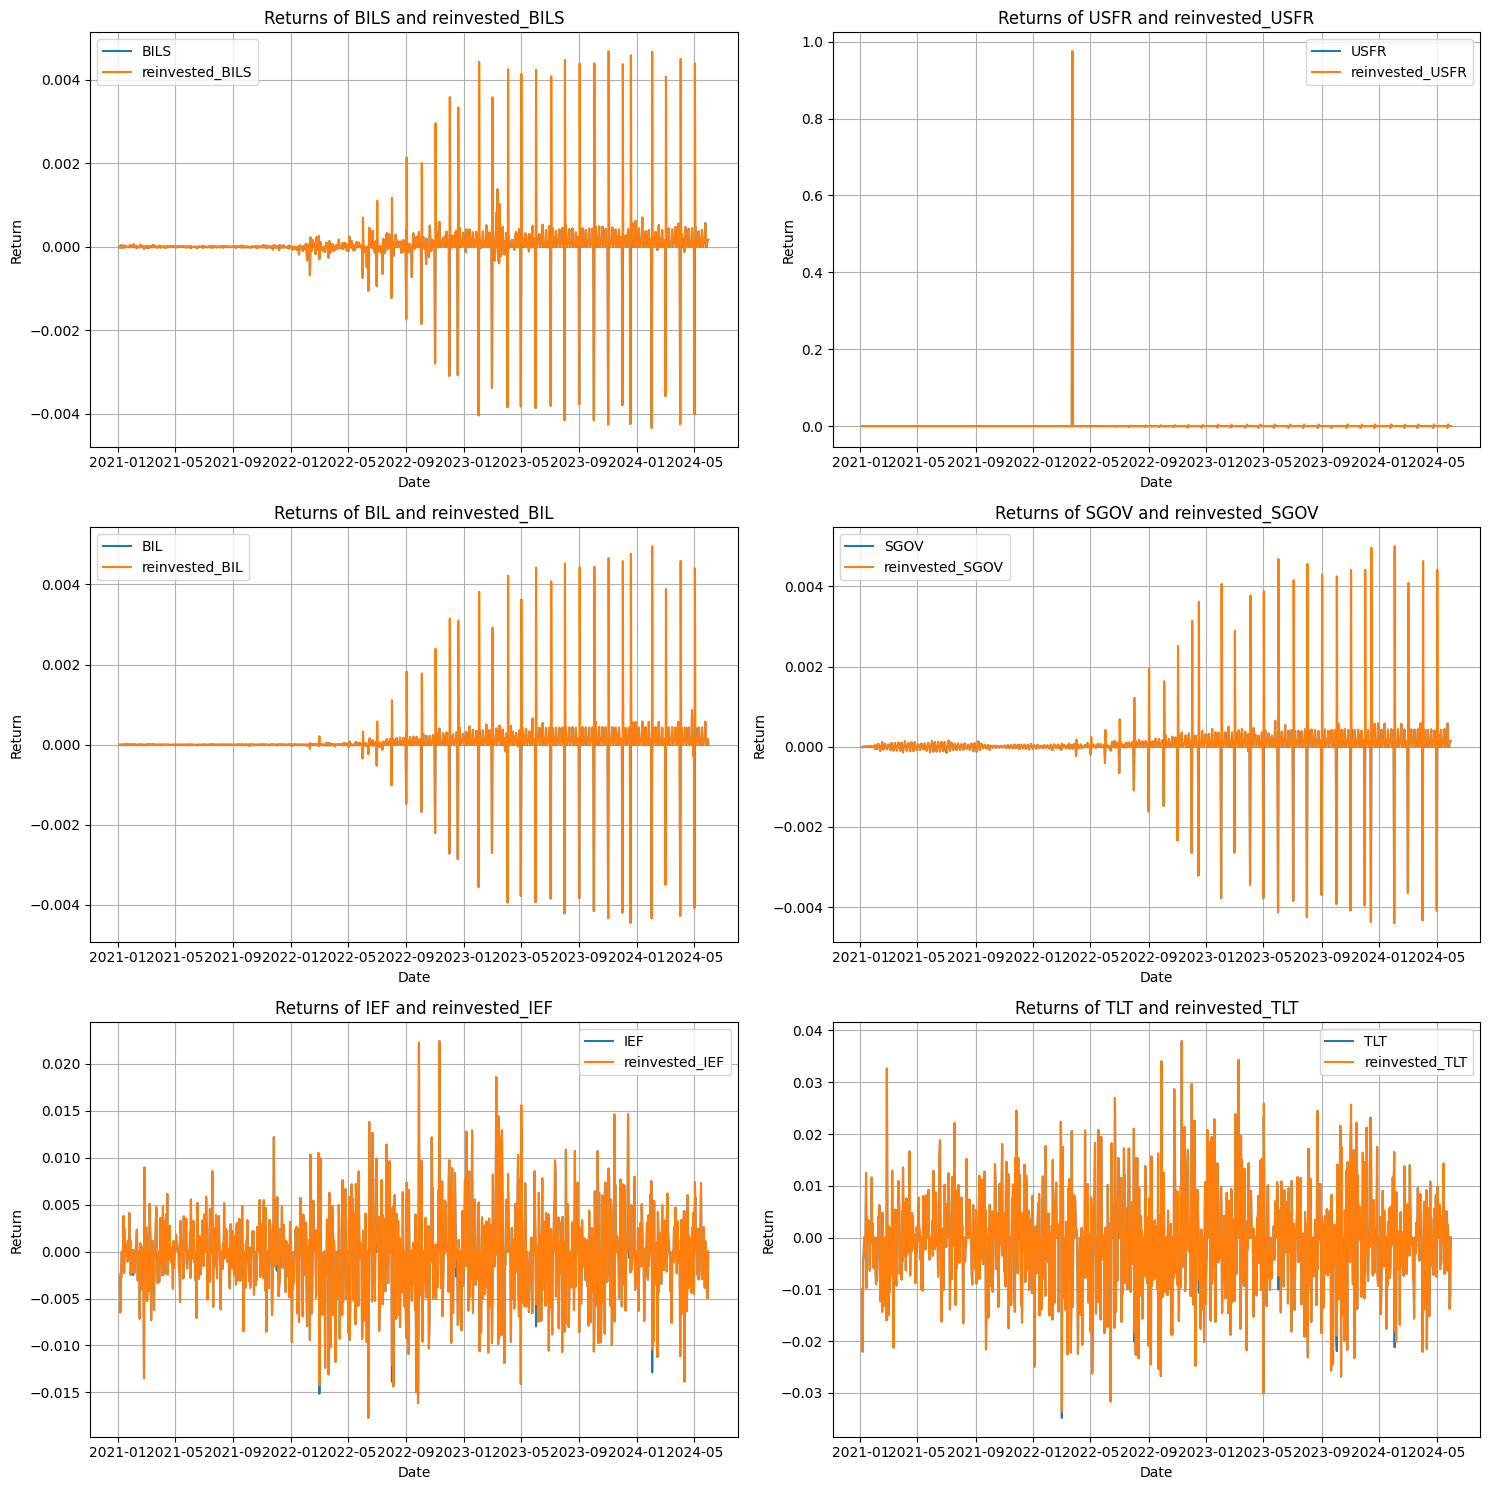

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

axes = axes.flatten()

# Loop through each ETF and create a plot
for i, etf in enumerate(etfs):
    ax = axes[i]
    ax.plot(returns.index, returns[etf], label=etf)
    ax.plot(returns.index, returns[f'{etf}_Reinvested'], label=f'reinvested_{etf}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.set_title(f'Returns of {etf} and reinvested_{etf}')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

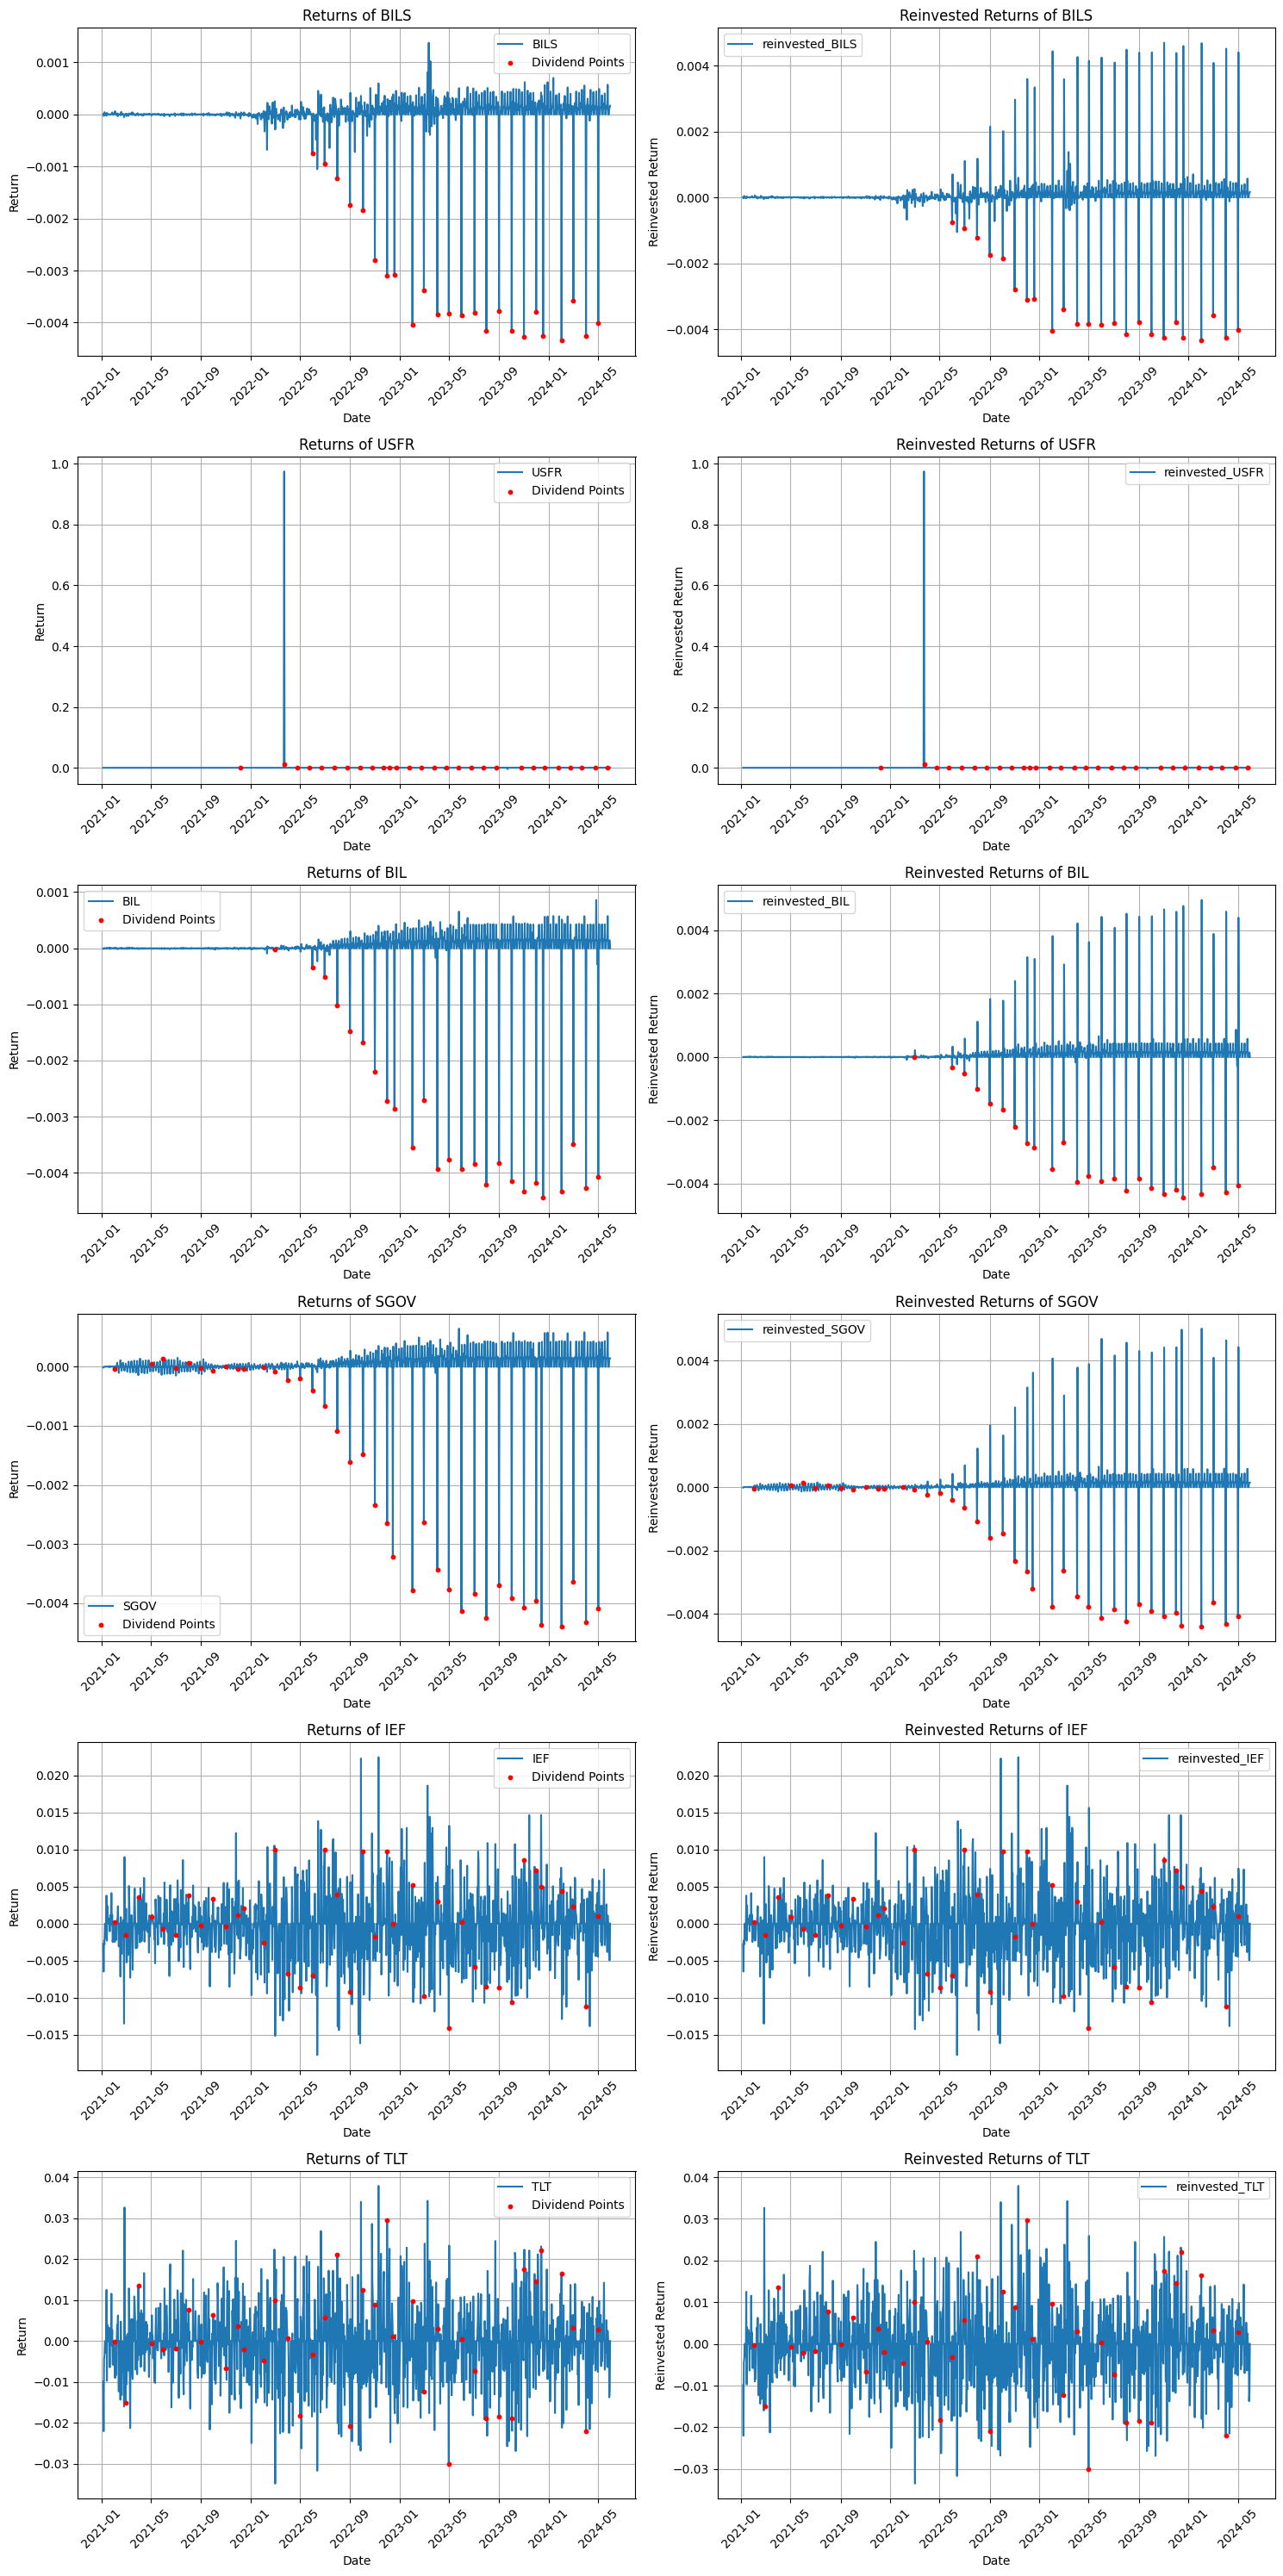

In [75]:
# Create a 6x2 subplot
fig, axes = plt.subplots(6, 2, figsize=(15, 30))

# Loop through each ETF and create a plot
for i, etf in enumerate(etfs):
    # Plot for the ETF returns
    ax1 = axes[i, 0]
    ax1.plot(returns.index, returns[etf], label=etf)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Return')
    ax1.set_title(f'Returns of {etf}')
    dividends = returns[returns[f'{etf}_Dividend'] != 0]
    ax1.scatter(dividends.index, returns.loc[dividends.index, etf], color='red', s=10, zorder=5, label='Dividend Points')
    ax1.legend()
    ax1.grid(True)
   
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    
    # Plot for the reinvested ETF returns
    ax2 = axes[i, 1]
    ax2.plot(returns.index, returns[f'{etf}_Reinvested'], label=f'reinvested_{etf}')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Reinvested Return')
    ax2.set_title(f'Reinvested Returns of {etf}')
    ax2.scatter(dividends.index, returns.loc[dividends.index, f'{etf}_Reinvested'], color='red', s=10, zorder=5)
    ax2.legend()
    ax2.grid(True)
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)


# Adjust layout
plt.tight_layout()
plt.show()


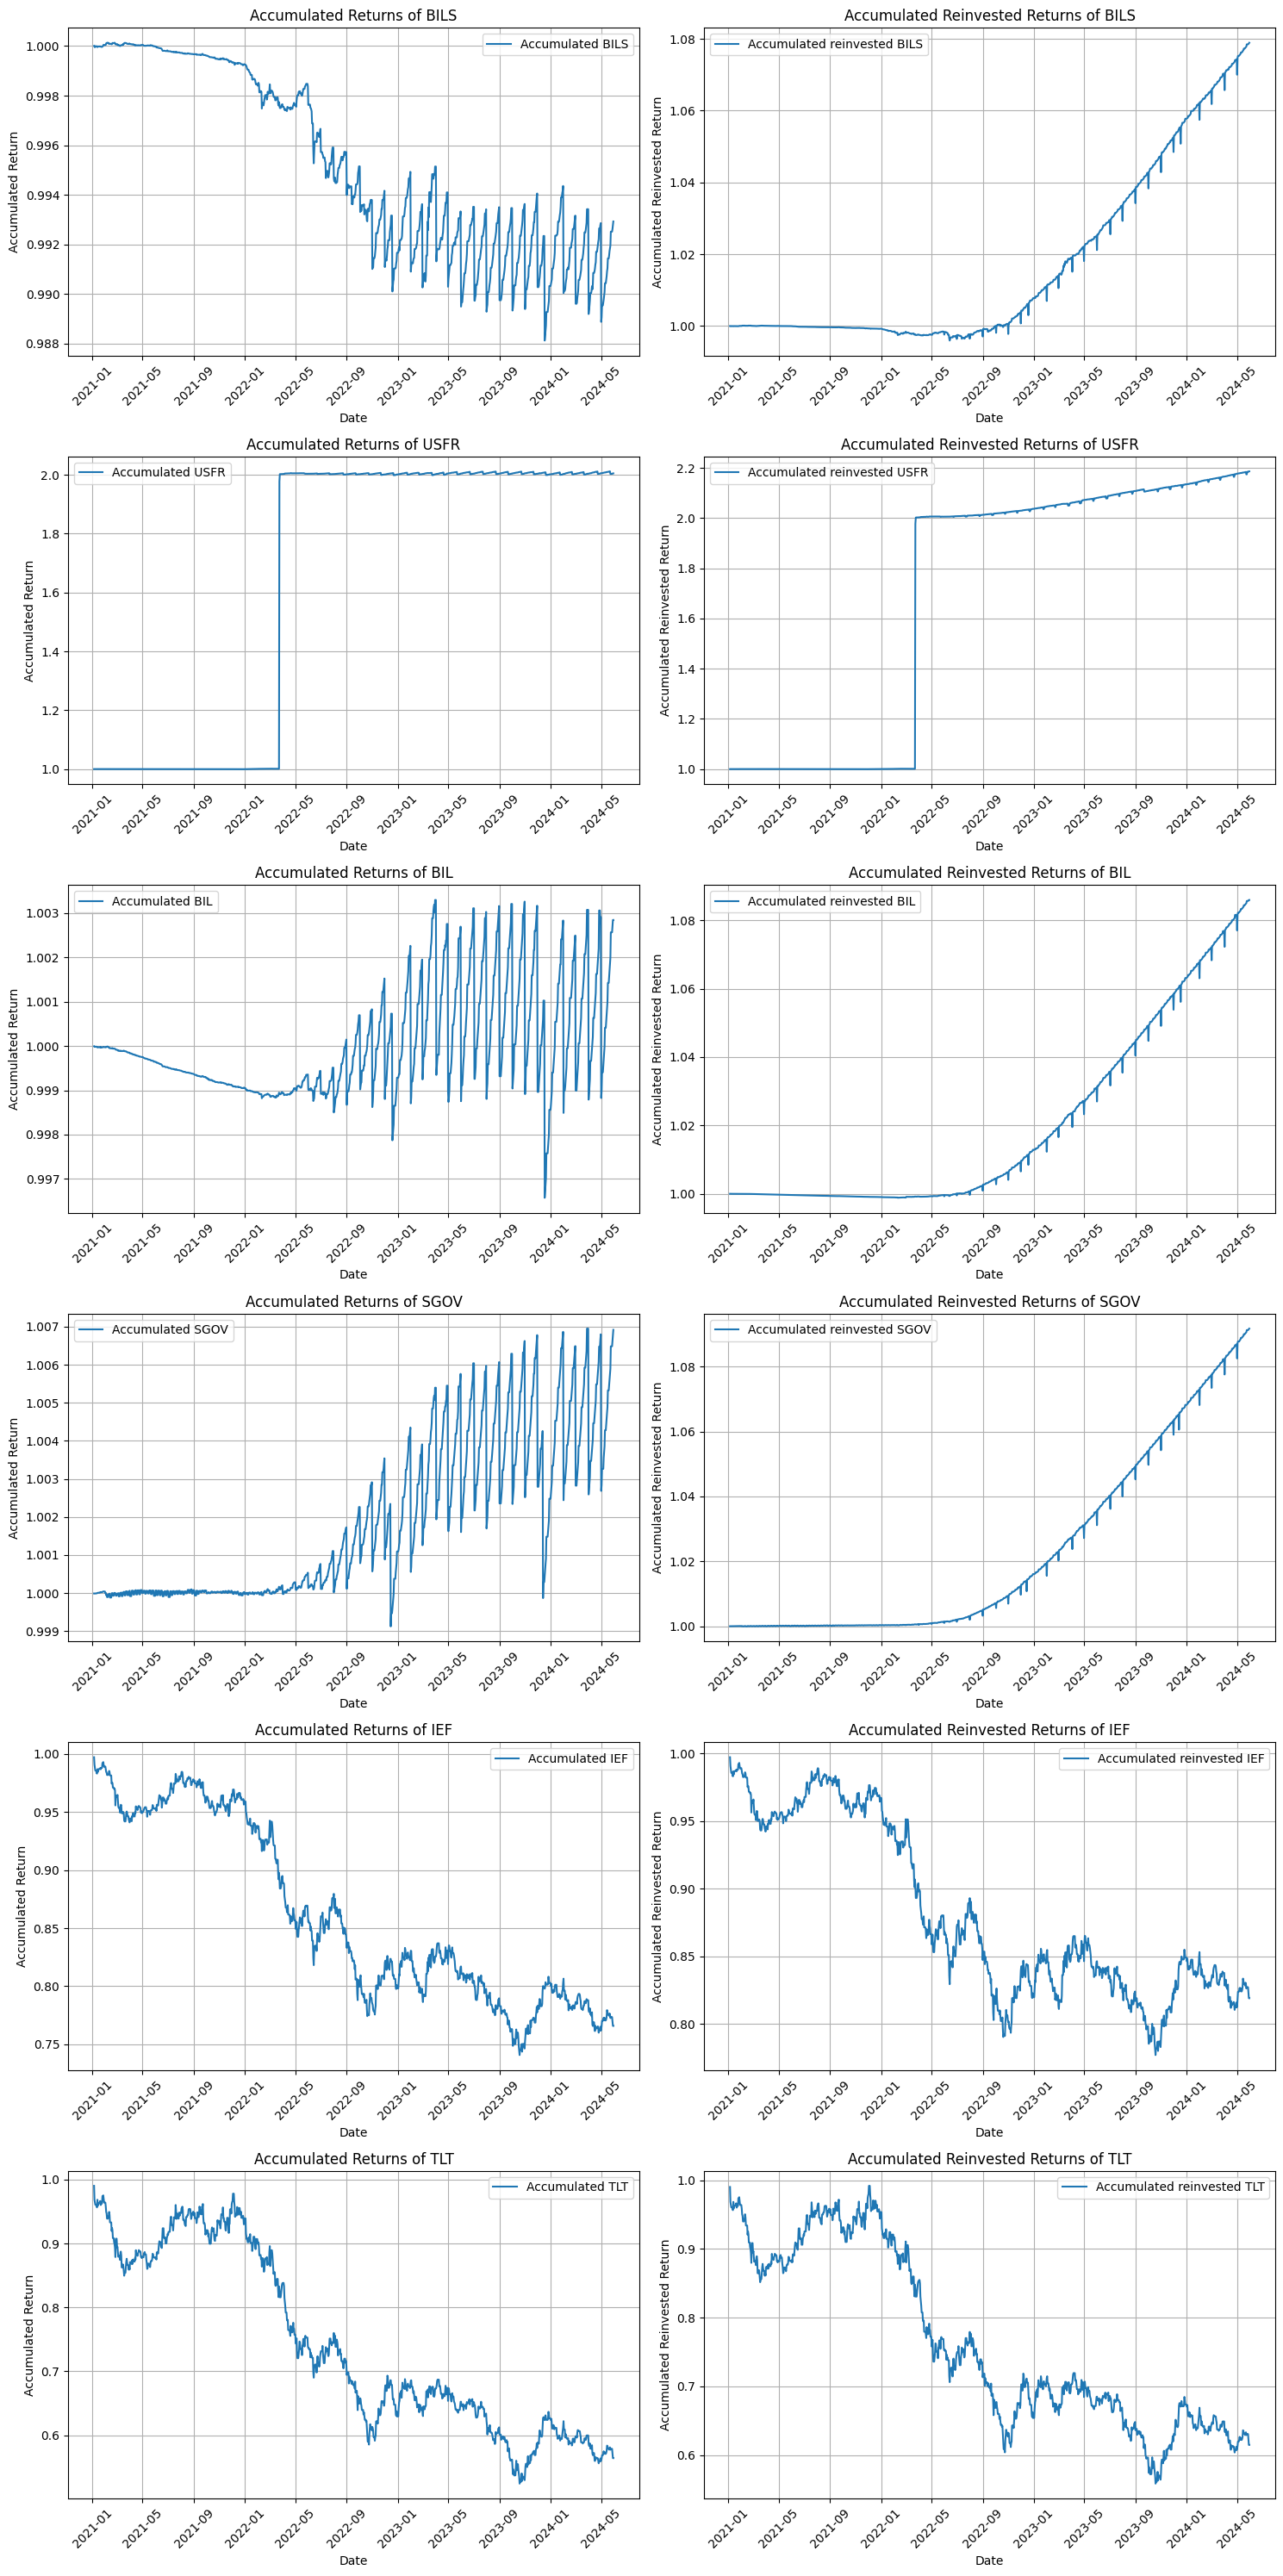

In [77]:
for etf in etfs:
    returns[f'acc_{etf}'] = (1 + returns[etf]).cumprod()
    returns[f'acc_adj_{etf}'] = (1 + returns[f'{etf}_Reinvested']).cumprod()

# Create a 6x2 subplot
fig, axes = plt.subplots(6, 2, figsize=(15, 30))

# Loop through each ETF and create a plot
for i, etf in enumerate(etfs):
    # Plot for the ETF returns
    ax1 = axes[i, 0]
    ax1.plot(returns.index, returns[f'acc_{etf}'], label=f'Accumulated {etf}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Accumulated Return')
    ax1.set_title(f'Accumulated Returns of {etf}')
    ax1.legend()
    ax1.grid(True)
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    
    
    # Plot for the reinvested ETF returns
    ax2 = axes[i, 1]
    ax2.plot(returns.index, returns[f'acc_adj_{etf}'], label=f'Accumulated reinvested {etf}')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Accumulated Reinvested Return')
    ax2.set_title(f'Accumulated Reinvested Returns of {etf}')
    ax2.legend()
    ax2.grid(True)

    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

# Adjust layout
plt.tight_layout()
plt.show()


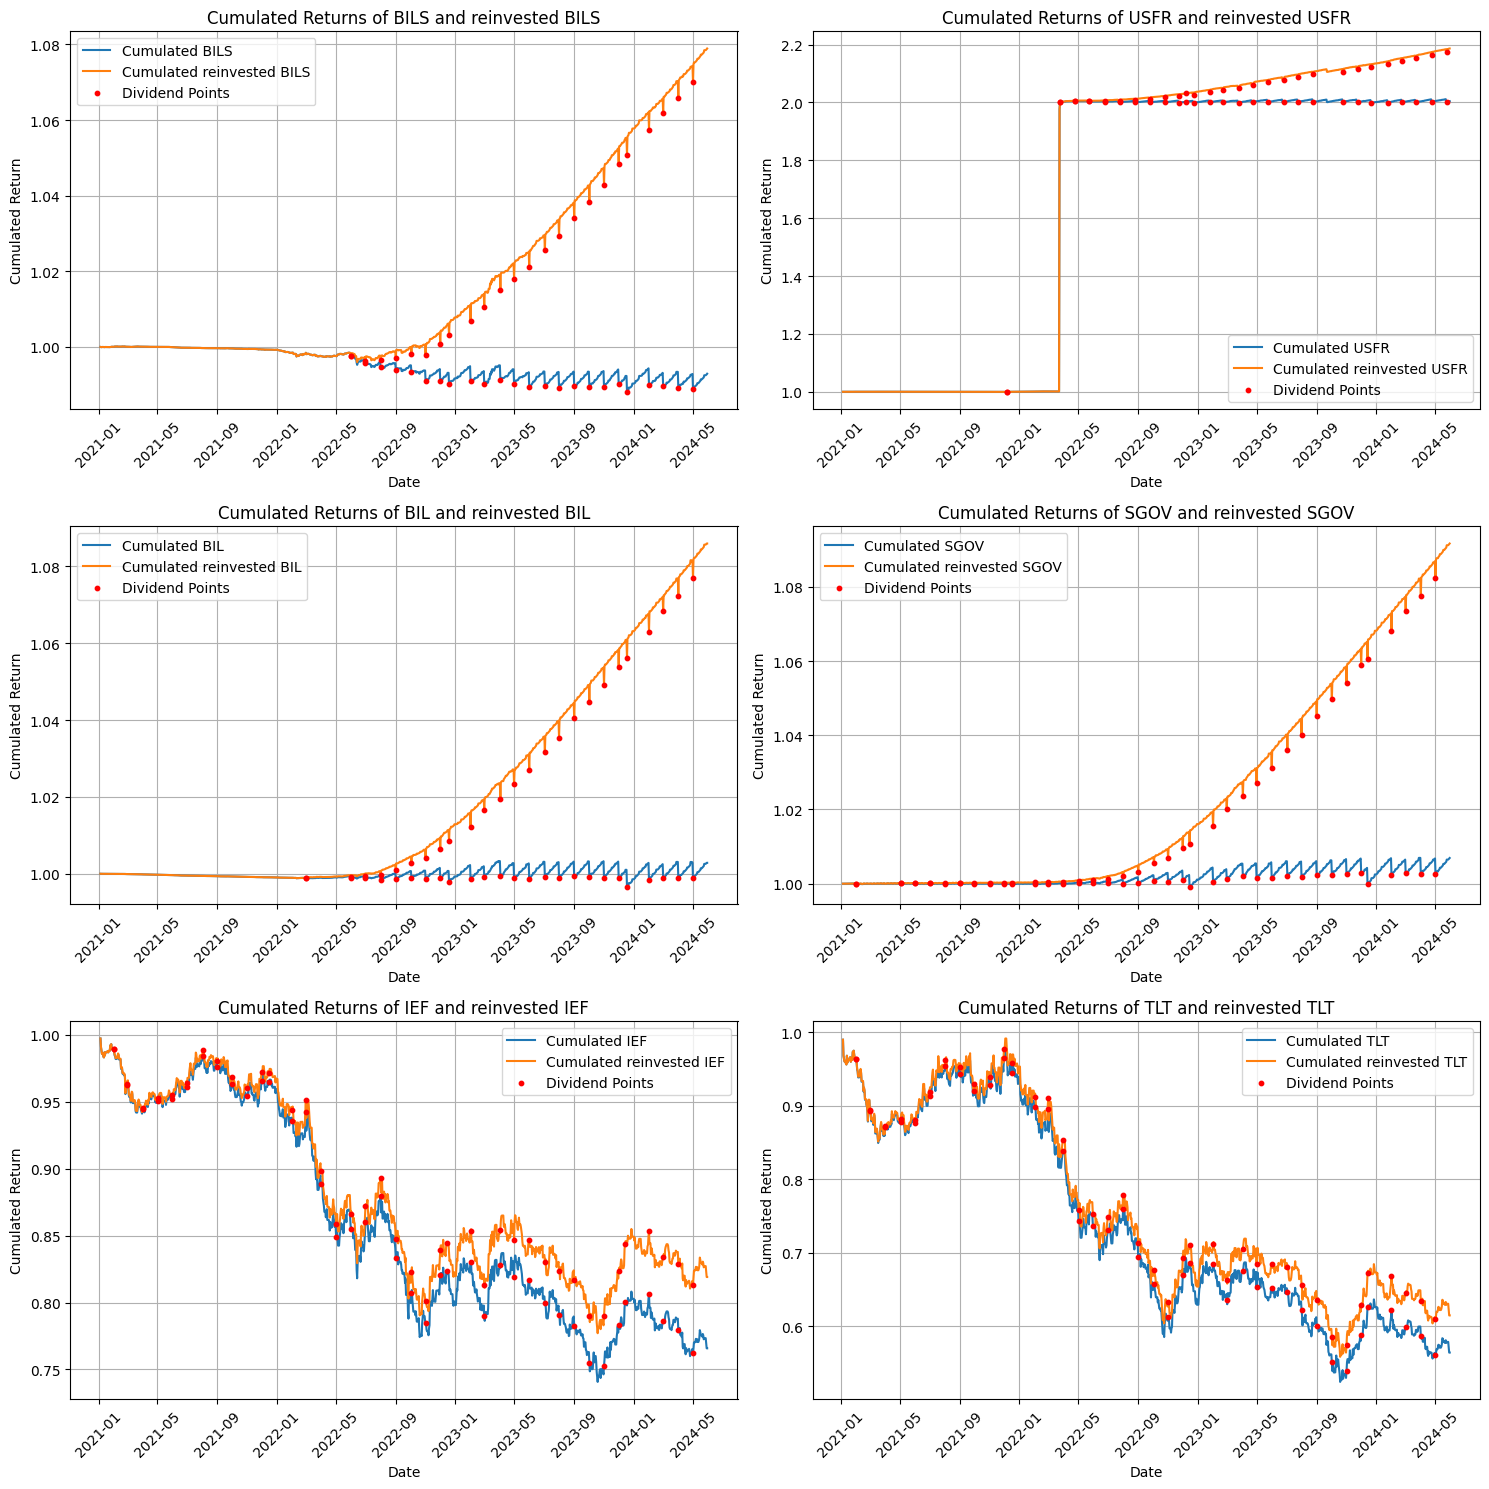

In [78]:
for etf in etfs:
    returns[f'acc_{etf}'] = (1 + returns[etf]).cumprod()
    returns[f'acc_adj_{etf}'] = (1 + returns[f'{etf}_Reinvested']).cumprod()

# Create a 3x2 subplot
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each ETF and create a plot
for i, etf in enumerate(etfs):
    ax = axes[i]
    # Plot accumulated returns
    ax.plot(returns.index, returns[f'acc_{etf}'], label=f'Cumulated {etf}')
    # Plot reinvested accumulated returns
    ax.plot(returns.index, returns[f'acc_adj_{etf}'], label=f'Cumulated reinvested {etf}')
    
    # Add smaller red markers for dividends
    dividends = returns[returns[f'{etf}_Dividend'] != 0]
    ax.scatter(dividends.index, returns.loc[dividends.index, f'acc_{etf}'], color='red', s=10, zorder=5, label='Dividend Points')
    ax.scatter(dividends.index, returns.loc[dividends.index, f'acc_adj_{etf}'], color='red', s=10, zorder=5)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulated Return')
    ax.set_title(f'Cumulated Returns of {etf} and reinvested {etf}')
    ax.legend()
    ax.grid(True)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Adjust layout
plt.tight_layout()
plt.show()


In [18]:
futures = pd.read_csv('/Users/liyihan/Desktop/Work/ASL/ETF Hedging Data/Future prices/Future prices.csv')
futures['Date'] = pd.to_datetime(futures['Date'])
futures.set_index('Date', inplace=True)
futures_returns = futures.pct_change().dropna()
reinvest_returns = returns[['BILS_Reinvested', 'USFR_Reinvested', 'BIL_Reinvested', 'SGOV_Reinvested', 'IEF_Reinvested', 'TLT_Reinvested']]
combined_data = pd.merge(reinvest_returns, futures_returns, left_index=True, right_index=True, how='left').dropna()
combined_data


,BILS_Reinvested,USFR_Reinvested,BIL_Reinvested,SGOV_Reinvested,IEF_Reinvested,TLT_Reinvested,FV1,FV2,SFR1,SFR2,SFR3,SFR4,SFR5,TU1,TU2,TY1,TY2,US1,US2,WN
Date,,,,,,,,,,,,,,,,,,,,
2021-01-11,-0.000016,0.000008,-0.000007,0.000002,-0.002022,-0.002875,-0.000622,-0.000623,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000106,-0.000106,-0.001715,-0.001613,-0.002407,-0.002431,-0.002769
2021-01-12,0.000005,-0.000025,-0.000004,0.000006,-0.000688,-0.001470,-0.000249,-0.000561,-0.000025,-0.000050,-0.000050,-0.000050,-0.000050,-0.000071,-0.000071,-0.000229,-0.000462,-0.000928,-0.000187,-0.001697
2021-01-13,-0.000026,0.000066,-0.000003,0.000004,0.003780,0.012519,0.001058,0.001060,0.000025,0.000050,0.000050,0.000050,0.000050,0.000000,0.000000,0.002749,0.003001,0.007061,0.006749,0.013133
2021-01-14,0.000030,-0.000079,0.000007,0.000004,-0.002304,-0.009711,-0.000311,-0.000311,-0.000025,-0.000050,0.000000,0.000000,0.000050,0.000035,0.000035,-0.001485,-0.001726,-0.006827,-0.006890,-0.010523
2021-01-15,-0.000006,0.000023,-0.000007,0.000002,0.002408,0.003963,0.001120,0.001121,0.000025,0.000000,0.000000,0.000050,0.000050,0.000177,0.000177,0.002174,0.002306,0.003530,0.003375,0.004007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.000111,-0.004342,0.000139,0.000142,-0.003852,-0.006358,-0.002291,-0.002282,0.000000,-0.000132,-0.000369,-0.000526,-0.000735,-0.001000,-0.001111,-0.002866,-0.002715,-0.003997,-0.003726,-0.004769
2024-05-24,0.000568,0.000068,0.000572,0.000583,0.001116,0.002518,-0.000370,-0.000369,0.000000,-0.000026,-0.000105,-0.000158,-0.000210,-0.000385,-0.000422,-0.000144,-0.000143,0.000000,0.000000,0.000504
2024-05-28,0.000110,0.000637,0.000137,0.000140,-0.004939,-0.013732,-0.001852,-0.001919,-0.000026,-0.000026,-0.000158,-0.000263,-0.000315,-0.000308,-0.000345,-0.003737,-0.003727,-0.008828,-0.009351,-0.013360


In [20]:
correlation_matrix = combined_data.corr()
correlation_matrix

,BILS_Reinvested,USFR_Reinvested,BIL_Reinvested,SGOV_Reinvested,IEF_Reinvested,TLT_Reinvested,FV1,FV2,SFR1,SFR2,SFR3,SFR4,SFR5,TU1,TU2,TY1,TY2,US1,US2,WN
BILS_Reinvested,1.000000,-0.006722,0.987563,0.878611,0.141381,0.082911,0.074040,0.022207,-0.002153,0.084052,0.109212,0.098980,0.084750,0.072185,-0.009532,0.052427,0.051805,0.039270,0.038387,0.026314
USFR_Reinvested,-0.006722,1.000000,-0.004016,-0.004754,-0.031999,-0.022329,-0.013381,-0.013704,0.003741,-0.011218,-0.021303,-0.019207,-0.014373,-0.009020,-0.008524,-0.013147,-0.012930,-0.004968,-0.005015,0.006015
BIL_Reinvested,0.987563,-0.004016,1.000000,0.885801,0.067676,0.034792,-0.014893,-0.066104,0.005687,0.033259,0.012749,-0.002909,-0.014166,-0.030986,-0.111276,-0.024454,-0.025770,-0.018623,-0.019320,-0.020720
SGOV_Reinvested,0.878611,-0.004754,0.885801,1.000000,0.057363,0.012493,-0.032188,-0.079021,0.005099,0.027070,0.005464,-0.011664,-0.023079,-0.042125,-0.121494,-0.043316,-0.043980,-0.043668,-0.044178,-0.045802
IEF_Reinvested,0.141381,-0.031999,0.067676,0.057363,1.000000,0.908767,0.886947,0.896212,-0.058207,0.223960,0.508475,0.626096,0.687475,0.750446,0.741058,0.926845,0.937140,0.910505,0.915465,0.864526
TLT_Reinvested,0.082911,-0.022329,0.034792,0.012493,0.908767,1.000000,0.701454,0.712394,-0.069546,0.116757,0.323003,0.417028,0.468850,0.530762,0.523452,0.794055,0.805534,0.910754,0.917860,0.942700
FV1,0.074040,-0.013381,-0.014893,-0.032188,0.886947,0.701454,1.000000,0.979125,-0.027947,0.326407,0.658756,0.778404,0.832095,0.916529,0.885174,0.941344,0.946493,0.821305,0.821276,0.733943
FV2,0.022207,-0.013704,-0.066104,-0.079021,0.896212,0.712394,0.979125,1.000000,-0.020770,0.325800,0.651699,0.771726,0.827126,0.902157,0.916841,0.950871,0.956654,0.832061,0.832500,0.743433
SFR1,-0.002153,0.003741,0.005687,0.005099,-0.058207,-0.069546,-0.027947,-0.020770,1.000000,0.720786,0.218617,0.006457,-0.110870,-0.019149,-0.015628,0.000172,-0.045088,-0.005276,-0.042856,-0.032095
SFR2,0.084052,-0.011218,0.033259,0.027070,0.223960,0.116757,0.326407,0.325800,0.720786,1.000000,0.773812,0.555541,0.409693,0.394103,0.374026,0.305267,0.288480,0.216198,0.196722,0.164875


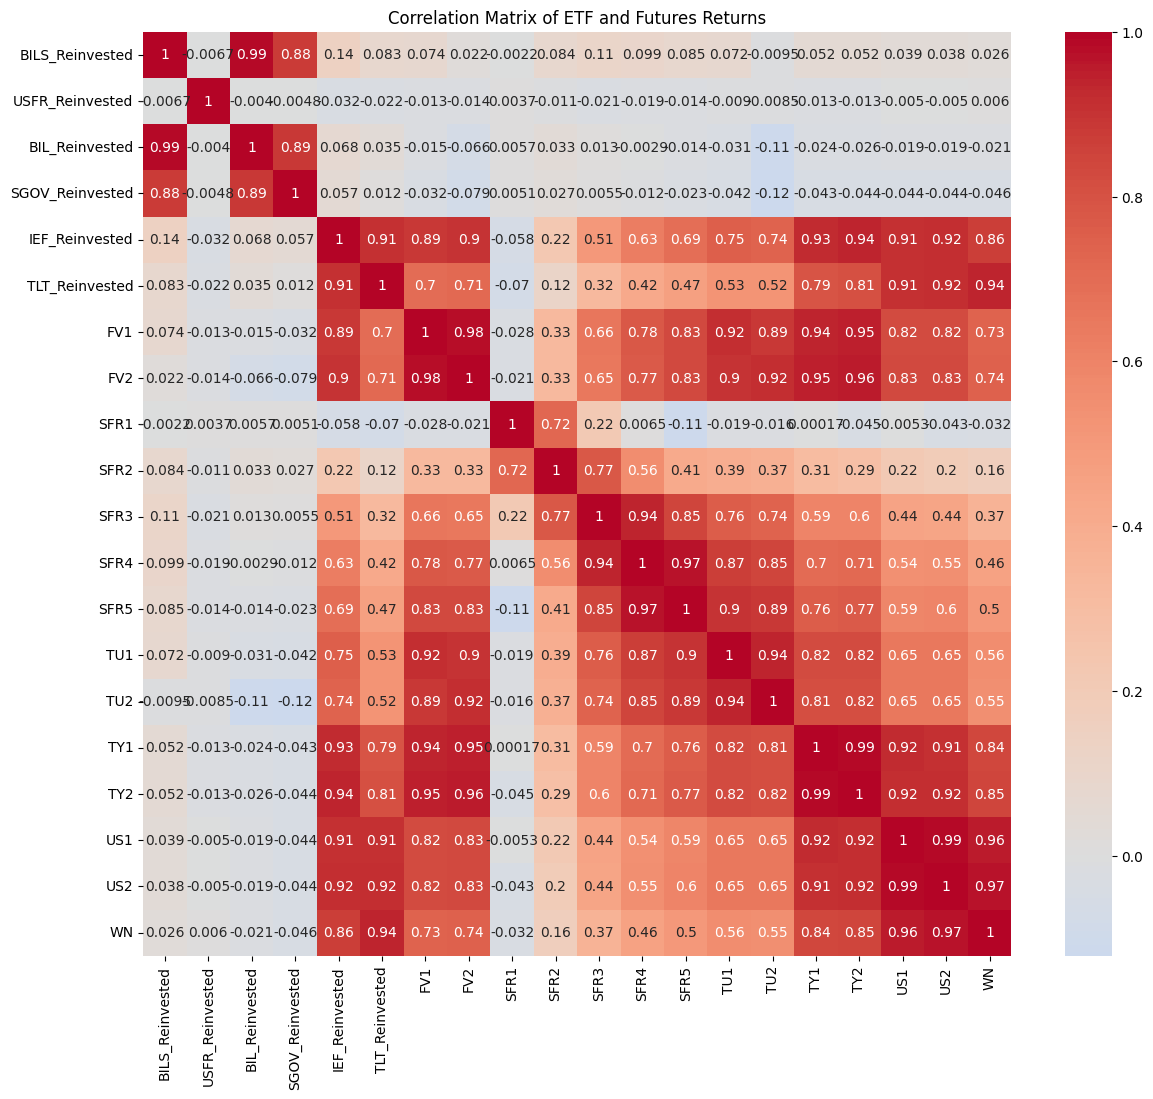

In [21]:
plt.figure(figsize=(14, 12)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of ETF and Futures Returns')

plt.savefig('correlation_matrix_high_res.png', dpi=300)

plt.show()

In [120]:
future_returns = returns.iloc[:, :2]
etf_returns = returns.iloc[:, 2:9]
Rf = pd.read_excel('/Users/liyihan/Desktop/Work/ASL/ETF Hedging Data/SOFR IR.xlsx')
Rf = Rf[['Effective Date', 'Rate (%)']].rename(columns={'Effective Date': 'Date', 'Rate (%)': 'Rf'})
Rf['Rf'] = Rf['Rf']/(100 * 252)
Rf['Date'] = pd.to_datetime(Rf['Date'])
Rf = Rf.sort_values(by='Date').set_index('Date')
Rf = Rf[Rf.index.isin(returns.index)]
returns.index = pd.to_datetime(returns.index)
returns = returns.join(Rf, how='left')
returns

/Users/liyihan/Desktop/Work/ASL/ETF Hedging Data/myenv/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,SFR1,SFR2,SFR3,SFR4,SFR5,TU1,TU2,adj_BIL,adj_BILS,Rf
Date,,,,,,,,,,
2021-01-11,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000106,-0.000106,0.000109,0.000050,0.000004
2021-01-12,-0.000025,-0.000050,-0.000050,-0.000050,-0.000050,-0.000071,-0.000071,-0.000109,-0.000050,0.000003
2021-01-13,0.000025,0.000050,0.000050,0.000050,0.000050,0.000000,0.000000,0.000000,0.000000,0.000003
2021-01-14,-0.000025,-0.000050,0.000000,0.000000,0.000050,0.000035,0.000035,0.000109,0.000050,0.000003
2021-01-15,0.000025,0.000000,0.000000,0.000050,0.000050,0.000177,0.000177,0.000000,0.000000,0.000003
...,...,...,...,...,...,...,...,...,...,...
2024-05-24,0.000000,-0.000026,-0.000105,-0.000158,-0.000210,-0.000385,-0.000422,0.000109,0.000101,0.000211
2024-05-28,-0.000026,-0.000026,-0.000158,-0.000263,-0.000315,-0.000308,-0.000345,-0.000109,0.000000,0.000211
2024-05-29,0.000026,0.000026,0.000053,0.000000,-0.000158,-0.000578,-0.000691,0.000218,0.000201,0.000212


/Users/liyihan/Desktop/Work/ASL/ETF Hedging Data/myenv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimal Hedge Ratios for adj_BILS:
           Best Asset  Hedge Ratio  Sharpe Ratio
Date                                            
2021-04-08        TU2     0.018163      0.046320
2021-04-09        TU2     0.018542     -0.002943
2021-04-12        TU2     0.019043     -0.000939
2021-04-13        TU2     0.018824      0.002637
2021-04-14        TU2     0.017611     -0.023903
...               ...          ...           ...
2024-05-24        TU1     0.075814      0.218001
2024-05-28        TU1     0.076745      0.211994
2024-05-29        TU1     0.088891      0.212230
2024-05-30        TU1     0.165732      0.178212
2024-05-31        TU1     0.168034      0.179602

[793 rows x 3 columns]




/Users/liyihan/Desktop/Work/ASL/ETF Hedging Data/myenv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimal Hedge Ratios for adj_BIL:
           Best Asset  Hedge Ratio  Sharpe Ratio
Date                                            
2021-04-08        TU2     0.021370     -0.056445
2021-04-09        TU2     0.026083     -0.055205
2021-04-12       SFR2    -0.205559     -0.050489
2021-04-13       SFR2    -0.211790     -0.051806
2021-04-14       SFR2    -0.155068     -0.075789
...               ...          ...           ...
2024-05-24        TU1     0.017756      0.222118
2024-05-28        TU1     0.019170      0.216663
2024-05-29        TU1     0.027057      0.211319
2024-05-30        TU2     0.088589      0.177076
2024-05-31        TU1     0.106359      0.182897

[793 rows x 3 columns]


          Cumulative Return  Total Excess Return  Daily Volatility  \
adj_BILS           0.189089             0.084905          0.000692   
adj_BIL            0.186479             0.082894          0.000680   

          Sharpe Ratio  
adj_BILS      0.155658  
adj_BIL       0.154618  


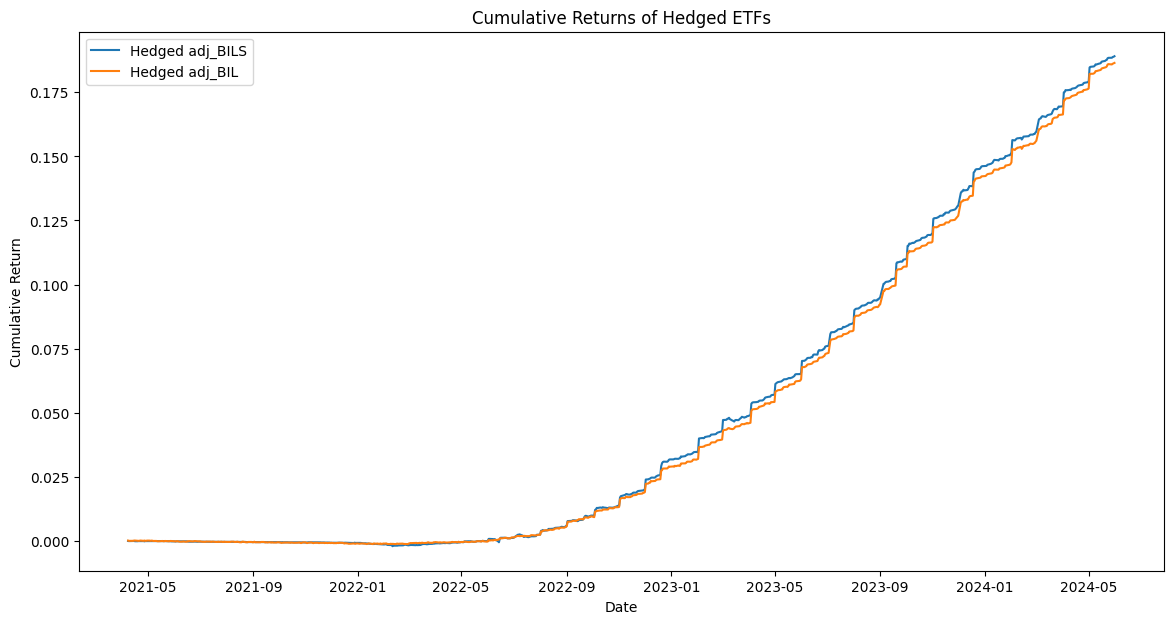

In [121]:
futures = ['SFR1', 'SFR2', 'SFR3', 'SFR4', 'SFR5', 'TU1', 'TU2']
etfs = ['adj_BILS', 'adj_BIL']
window_size = 60  # 设定滚动窗口大小，例如252天

# 初始化存储对冲后收益率的DataFrame
hedged_returns = pd.DataFrame(index=returns.index)

# 计算滚动窗口内的对冲比率并应用对冲策略
for etf in etfs:
    best_assets = []
    best_hedge_ratios = []
    rolling_sharpe_ratios = []
    
    for i in range(window_size, len(returns)):
        best_asset = None
        best_hedge_ratio = None
        best_sharpe_ratio = float('-inf')
        
        window_returns = returns.iloc[i-window_size:i]
        
        for asset in futures:
            if etf != asset:
                X = sm.add_constant(window_returns[asset])
                model = sm.OLS(window_returns[etf], X).fit()
                hedge_ratio = model.params[1]
                hedged_returns_window = window_returns[etf] - hedge_ratio * window_returns[asset]
                
                # 将 hedged_returns_window 和 Rf 对齐
                hedged_returns_window = hedged_returns_window - window_returns['Rf']
                
                excess_returns = hedged_returns_window
                daily_volatility = excess_returns.std()
                
                # 计算日均超额收益
                mean_excess_return = np.mean(excess_returns)
                if daily_volatility != 0:  # 避免除以零
                    sharpe_ratio = mean_excess_return / daily_volatility
                else:
                    sharpe_ratio = float('-inf')
                
                if sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = sharpe_ratio
                    best_hedge_ratio = hedge_ratio
                    best_asset = asset
        
        best_assets.append(best_asset)
        best_hedge_ratios.append(best_hedge_ratio)
        rolling_sharpe_ratios.append(best_sharpe_ratio)
        hedged_returns.loc[returns.index[i], etf] = returns.loc[returns.index[i], etf] - best_hedge_ratio * returns.loc[returns.index[i], best_asset]


    optimal_hedge_ratios = pd.DataFrame({
        'Best Asset': best_assets,
        'Hedge Ratio': best_hedge_ratios,
        'Sharpe Ratio': rolling_sharpe_ratios
    }, index=returns.index[window_size:])
    
    print(f'Optimal Hedge Ratios for {etf}:')
    print(optimal_hedge_ratios)
    print('\n')

# 计算策略表现指标
def calculate_performance(returns, rf):
    cumulative_return = (1 + returns).cumprod() - 1
    excess_returns = returns - rf
    total_excess_return = excess_returns.sum()
    mean_excess_return = excess_returns.mean()
    daily_volatility = excess_returns.std()
    sharpe_ratio = mean_excess_return / daily_volatility if daily_volatility != 0 else float('-inf')
    return cumulative_return, total_excess_return, daily_volatility, sharpe_ratio

performance_metrics = {}
rf_series = returns['Rf']

for etf in hedged_returns.columns:
    hedged_etf_returns = hedged_returns[etf].dropna()
    rf_for_period = rf_series.loc[hedged_etf_returns.index]
    cumulative_return, total_excess_return, daily_volatility, sharpe_ratio = calculate_performance(hedged_etf_returns, rf_for_period)
    performance_metrics[etf] = {
        'Cumulative Return': cumulative_return[-1],
        'Total Excess Return': total_excess_return,
        'Daily Volatility': daily_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

performance_df = pd.DataFrame(performance_metrics).T
print(performance_df)

# 可视化累计收益
plt.figure(figsize=(14, 7))
for etf in hedged_returns.columns:
    cumulative_return = (1 + hedged_returns[etf].dropna()).cumprod() - 1
    plt.plot(cumulative_return, label=f'Hedged {etf}')

plt.title('Cumulative Returns of Hedged ETFs')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
